In [154]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.size'] = 12.0

In [155]:
p_color = "#4D9DE0"
s_color = "#E15554"

In [156]:
def theoretical_R_p(incident_angle, k):
    if k > 1:
        critical_angle = theoretical_critical_angle(k)
        cleaned_incident_angles = incident_angle[incident_angle <= critical_angle]
        filler_ones = np.ones_like(incident_angle[incident_angle > critical_angle])
    else:
        cleaned_incident_angles = incident_angle
        filler_ones = np.array([])

    theory = (((np.cos(cleaned_incident_angles) - k * np.sqrt(1 - k**2 * np.sin(cleaned_incident_angles)**2)) / 
             (np.cos(cleaned_incident_angles) + k * np.sqrt(1 - k**2 * np.sin(cleaned_incident_angles)**2)))**2)

    if (1 - k**2 * np.sin(cleaned_incident_angles)**2 < 0).any():
        print(k, critical_angle, incident_angle, cleaned_incident_angles)

    filled_theory = np.append(theory, filler_ones)

    return filled_theory

def theoretical_R_s(incident_angle, k):
    if k > 1:
        critical_angle = theoretical_critical_angle(k)
        cleaned_incident_angles = incident_angle[incident_angle <= critical_angle]
        filler_ones = np.ones_like(incident_angle[incident_angle > critical_angle])
    else:
        cleaned_incident_angles = incident_angle
        filler_ones = np.array([])

    theory = (((np.sqrt(1 - k**2 * np.sin(cleaned_incident_angles)**2) - k * np.cos(cleaned_incident_angles)) / 
             (np.sqrt(1 - k**2 * np.sin(cleaned_incident_angles)**2) + k * np.cos(cleaned_incident_angles)))**2)

    filled_theory = np.append(theory, filler_ones)

    return filled_theory

def theoretical_T_p(incident_angle, k):
    return 1 - theoretical_R_p(incident_angle, k)

def theoretical_T_s(incident_angle, k):
    return 1 - theoretical_R_s(incident_angle, k)

def theoretical_brewster_angle(n_1, n_2):
    return np.atan(n_2 / n_1)

def theoretical_critical_angle(k):
    return np.asin(1 / k)

In [157]:
class Measurement:
    def __init__(self, data_file_name: str, reflection: bool, air_to_glass: bool) -> None:
        ia, da, bgp, ubgp, bgs, ubgs, mp, ump, ms, ums = np.loadtxt(f"data/{data_file_name}.txt", unpack=True)

        tib, tibu, tia, tiau = np.loadtxt(f"data/{data_file_name}Intensities.txt", unpack=True)

        tibp = ufloat(tib[0], tibu[0] / 1000000) - ufloat(tib[2], tibu[2] / 1000000) #type: ignore
        tibs = ufloat(tib[1], tibu[1] / 1000000) - ufloat(tib[3], tibu[3] / 1000000) #type: ignore
        tiap = ufloat(tia[0], tiau[0] / 1000000) - ufloat(tia[2], tiau[2] / 1000000) #type: ignore
        tias = ufloat(tia[1], tiau[1] / 1000000) - ufloat(tia[3], tiau[3] / 1000000) #type: ignore

        self.air_to_glass = air_to_glass
        self.reflection = reflection
        self.n_1 = 1 if air_to_glass else 1.5
        self.n_2 = 2.5 - self.n_1
        self.k = self.n_1 / self.n_2

        self.incident_angle = np.array([ufloat(iai, 1) for iai in ia])
        self.detector_angle = np.array([ufloat(dai, 1) for dai in da])
        self.background_p = np.array([ufloat(bg / 1000, bgu / 1000000) for bg, bgu in zip(bgp, ubgp)])
        self.background_s = np.array([ufloat(bg / 1000, bgu / 1000000) for bg, bgu in zip(bgs, ubgs)])
        self.measured_p = np.array([ufloat(m / 1000, mu / 1000000) for m, mu in zip(mp, ump)])
        self.measured_s = np.array([ufloat(m / 1000, mu / 1000000) for m, mu in zip(ms, ums)])

        self.total_intensity_p = (tibp + tiap) / 2  # type: ignore
        self.total_intensity_s = (tibs + tias) / 2  # type: ignore

        self.measured_percentage_p = (self.measured_p - self.background_p) / self.total_intensity_p
        self.measured_percentage_s = (self.measured_s - self.background_s) / self.total_intensity_s

        self.fit()

    def fit(self):
        theoretical_p = lambda theta, k, offset: (theoretical_R_p(theta + offset, k) if self.reflection else theoretical_T_p(theta + offset, k))
        theoretical_s = lambda theta, k, offset: (theoretical_R_s(theta + offset, k) if self.reflection else theoretical_T_s(theta + offset, k))

        incident_angles = [ia.nominal_value for ia in self.incident_angle]

        p_values = [m.nominal_value if m.nominal_value > 0 else 0 for m in self.measured_percentage_p]
        s_values = [m.nominal_value if m.nominal_value > 0 else 0 for m in self.measured_percentage_s]
        #p_values = [m.nominal_value for m in self.measured_percentage_p]
        #s_values = [m.nominal_value for m in self.measured_percentage_s]
        p_errors = [m.std_dev for m in self.measured_percentage_p]
        s_errors = [m.std_dev for m in self.measured_percentage_s]

        incident_angles_rad = np.deg2rad(incident_angles)
        offset_bounds = (-min(incident_angles_rad), max(incident_angles_rad))
        k_bounds = (0, 1) if self.air_to_glass else (1, 5)
        bounds = ([k_bounds[0], offset_bounds[0]], [k_bounds[1], offset_bounds[1]])

        p_fit = curve_fit(theoretical_p, incident_angles_rad, p_values, (self.k, 0), p_errors, nan_policy='omit', bounds=bounds)
        s_fit = curve_fit(theoretical_s, incident_angles_rad, s_values, (self.k, 0), s_errors, nan_policy='omit', bounds=bounds)

        self.fitted_func_p = lambda theta: theoretical_p(theta, p_fit[0][0], p_fit[0][1])
        self.fitted_func_s = lambda theta: theoretical_s(theta, s_fit[0][0], s_fit[0][1])

        self.fitted_params_p = p_fit[0]
        self.fitted_params_s = s_fit[0]

        self.fitted_params_p_uncert = np.sqrt(np.diag(p_fit[1]))
        self.fitted_params_s_uncert = np.sqrt(np.diag(s_fit[1]))

    def plot(self, ax):
        _, ax = plt.subplots()

        ia_values = [m.nominal_value for m in self.incident_angle]
        ia_errors = [m.std_dev for m in self.incident_angle]
        p_values = [m.nominal_value for m in self.measured_percentage_p]
        s_values = [m.nominal_value for m in self.measured_percentage_s]
        p_errors = [m.std_dev for m in self.measured_percentage_p]
        s_errors = [m.std_dev for m in self.measured_percentage_s]

        ax.errorbar(ia_values, p_values, fmt='-o', yerr=p_errors, xerr=ia_errors,
                    c=p_color, label=f"${'R' if self.reflection else 'T'}_p$", 
                    capsize=4, ecolor='k')
        ax.errorbar(ia_values, s_values, fmt='--o', yerr=s_errors, xerr=ia_errors,
                    c=s_color, label=f"${'R' if self.reflection else 'T'}_s$", 
                    capsize=4, ecolor='k')

        ax.set_xlim(0, 90)
        ax.set_ylim(0, 1)
        ax.set_xlabel(r"Incident angle [$^\circ$]")
        ax.set_ylabel(f"{'Reflected' if self.reflection else 'Transmitted'}")
        ax.set_title(f"{'Air' if self.air_to_glass else 'Glass'} to {'Glass' if self.air_to_glass else 'Air'}")

        ax.set_xticks(np.linspace(0, 90, 7))
        ax.set_yticks(np.linspace(0, 1, 6))

        ba = np.rad2deg(theoretical_brewster_angle(self.n_1, self.n_2))

        if not self.air_to_glass:
            ca = np.rad2deg(theoretical_critical_angle(self.k))
        # if self.air_to_glass else ca
        theoretical_incident_angles = np.linspace(0, 90, 100)

        args = (np.deg2rad(theoretical_incident_angles), self.k)

        theoretical_ps = theoretical_R_p(*args) if self.reflection else theoretical_T_p(*args)
        theoretical_ss = theoretical_R_s(*args) if self.reflection else theoretical_T_s(*args)

        ax.plot(theoretical_incident_angles, theoretical_ps, color='k', label=f"Theoretical ${'R' if self.reflection else 'T'}_p$")
        ax.plot(theoretical_incident_angles, theoretical_ss, "--", color='k', label=f"Theoretical ${'R' if self.reflection else 'T'}_s$")

        fitted_ps = self.fitted_func_p(np.deg2rad(theoretical_incident_angles))
        fitted_ss = self.fitted_func_s(np.deg2rad(theoretical_incident_angles))

        fitted_p_label = (fr"$\mathrm{{Fitted}}\ "
                          fr"{'R' if self.reflection else 'T'}_p"
                          fr"\ - \mathrm{{k}}={self.fitted_params_p[0]:.2f}"
                          fr"\pm{self.fitted_params_p_uncert[0]:.2f},\ "
                          fr"\mathrm{{offset}}="
                          fr"{np.rad2deg(self.fitted_params_p[1]):.2f}"
                          fr"\pm{np.rad2deg(self.fitted_params_p_uncert[1]):.2f}$")

        fitted_s_label = (fr"$\mathrm{{Fitted}}\ "
                          fr"{'R' if self.reflection else 'T'}_s"
                          fr"\ - \mathrm{{k}}={self.fitted_params_s[0]:.2f}"
                          fr"\pm{self.fitted_params_s_uncert[0]:.2f},\ "
                          fr"\mathrm{{offset}}="
                          fr"{np.rad2deg(self.fitted_params_s[1]):.2f}"
                          fr"\pm{np.rad2deg(self.fitted_params_s_uncert[1]):.2f}$")

        ax.plot(theoretical_incident_angles, fitted_ps, ':', color=p_color, label=fitted_p_label)
        ax.plot(theoretical_incident_angles, fitted_ss, ":", color=s_color, label=fitted_s_label)

        ax.plot([ba, ba], [0, 1], ':', color='k')
        ax.text(ba + 1, 0.45, r"$\theta_B$")
        if not self.air_to_glass:
            ax.plot([ca, ca], [0, 1], ':', color='k')
            ax.text(ca + 1, 0.45, r"$\theta_C$")

        ax.legend(fontsize=9)

In [158]:
air_to_glass_reflected_filename = "Data1"
glass_to_air_reflected_filename = "Data2"
air_to_glass_transmitted_filename = "Data3"
glass_to_air_transmitted_filename = "Data4"

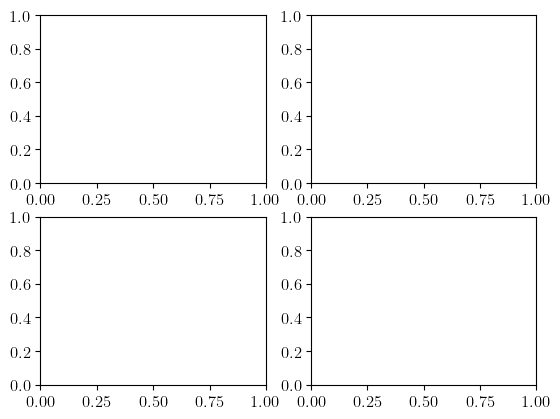

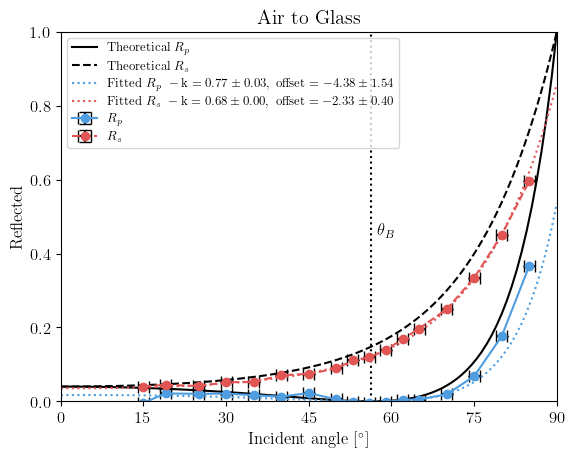

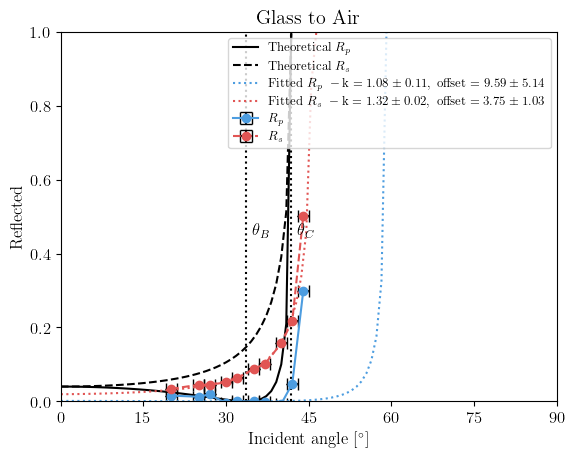

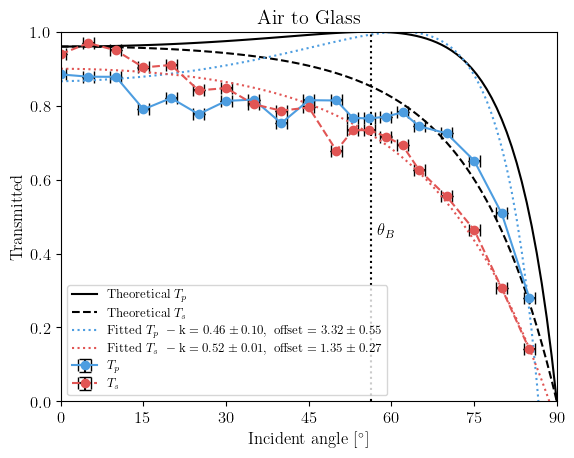

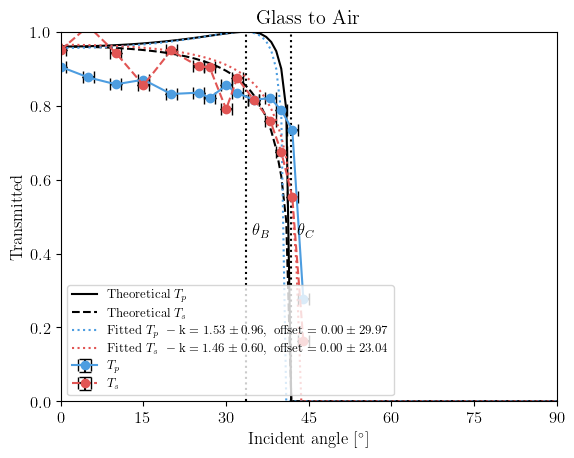

In [159]:
measurement1 = Measurement(air_to_glass_reflected_filename, True, True)
measurement2 = Measurement(glass_to_air_reflected_filename, True, False)
measurement3 = Measurement(air_to_glass_transmitted_filename, False, True)
measurement4 = Measurement(glass_to_air_transmitted_filename, False, False)

fig, ax = plt.subplots(2, 2)

measurement1.plot(ax[0][0])
measurement2.plot(ax[0][1])
measurement3.plot(ax[1][0])
measurement4.plot(ax[1][1])